# Quantitative Methods of Evaluating Song Lyrics
## Web Scraping, Natural Language Processing, and Visualizing High-Dimensional Data
### Timothy Mitchell

Advances in text mining and natural language processing have made it viable to study text using methods normally reserved for numerical data. Here I present an analysis of song lyrics based on a data set of 200,000+ songs scraped from the web. I find that several summary statistics follow a smooth unimodal distribution, including total words, unique words, and percentage of words that are unique. These distributions differ as a function of genre, with large effect sizes observed. One of the biggest challenges in natural language processing is the development of tools to measure and score literary devices. I propose a novel framework to measure consonance scores and present an original unsupervised algorithm that can detect consonance in text data. These provide a statistical basis for comparing frequencies of literary devices across songs, genres, and artists.

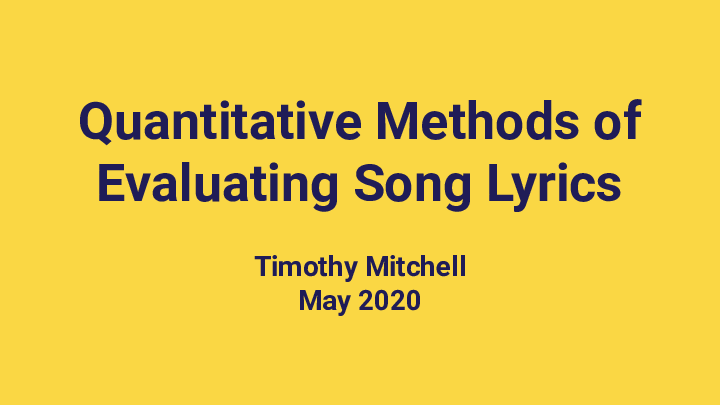

In [4]:
from wand.image import Image as WImage
WImage(filename='QMESL.pdf[0]')

# Data Collection (Python Portion)

### 1. `lyrics.py`

In [ ]:
### NOT RUN

### lyrics.py (adapted from another author) gathers lyrics from a large lyric aggegrator site

# encoding=utf8
import httplib
import sys
import threading

from Queue import Queue
from threading import Thread

reload(sys)
sys.setdefaultencoding('utf8')


import os
import requests
from bs4 import BeautifulSoup
from slugify import slugify

from os.path import join

done_artists_set = set()


UAH = {'User-Agent':'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.100 Safari/537.36'}

main_d = os.getcwd()
try:
	os.mkdir(join(main_d, 'results'))
except OSError:
	pass

main_d = join(main_d, 'results')

def extractLyrics():
	while True:
		i = q_of_artist.get()
		extractLyricsforArtist(i)
		q_of_artist.task_done()

def extractLyricsforArtist(data):
		global done_artists_set

		artist = data[0]
		genre = data[1]
		link = data[2]

		if artist.strip() in done_artists_set:
			return

		try:
			os.mkdir(join(main_d, slugify(unicode(artist))))
		except OSError:
			pass

		genre_file = open(join(main_d, slugify(unicode(artist)), 'genre.txt'), 'w')
		genre_file.write(genre)
		genre_file.close()

		count=1

		pre_link =	link.strip().replace('lyrics.html', '')
		while True:

			link = pre_link + 'alpage-%d.html' %(count)

			try:
				response = requests.get(link, headers=UAH)
			except:
				print 'crashed at %s' %(link)
				continue


			if response.url != link:
				break

			soup = BeautifulSoup(response.text, 'html.parser')

			for tr in soup.find_all('tr'):


				new_soup = BeautifulSoup(str(tr), 'html.parser')
				tds = new_soup.find_all('td')

				if not tds:
					continue
				else:
					song_soup = BeautifulSoup(str(tds[1]), 'html.parser')
					year_soup = BeautifulSoup(str(tds[2]), 'html.parser')

					song_name = ''.join(song_soup.a.contents).replace(' Lyrics', '').strip()

					song_link = song_soup.a['href']

					year = ''.join(year_soup.td.contents)

					if not year:
						year = 'Not Available'
					elif not year.isdigit():
						continue

					try:
						os.mkdir(join(main_d, slugify(unicode(artist)), year))
					except OSError:
						pass

					try:
						response = requests.get(song_link, headers=UAH)
					except:
						print 'crashed at %s' %(song_link)
						continue

					lyrics_soup = BeautifulSoup(response.text, 'html.parser')
					song = []
					for verse in lyrics_soup.findAll('p', {'class': 'verse'}):
						data = verse.text
						song.append(data)

					song_file = open(join(main_d, slugify(unicode(artist)), year, slugify(song_name)), 'w')
					song_file.write('\n'.join(song))
					song_file.close()
			count+=1
		with open('done_artists', 'a') as done_artists:
			done_artists.write(artist)
			done_artists.write('\n')
			done_artists_set.add(artist.strip())


q_of_artist = Queue()
count_artists = 0

with open('done_artists', 'r') as done_artists:
	for artist in done_artists:
		done_artists_set.add(artist.strip())
try:
	with open('artist.csv') as artists:
		pwd = main_d
		for line in artists:
			data = line.split('\t')
			artist = data[0]
			genre = data[1]
			link = data[2]
			info = [artist, genre, link]
			q_of_artist.put(info)
			count_artists += 1

except KeyboardInterrupt:
	sys.exit(1)

for i in range(100):
	t= Thread(target = extractLyrics)
	t.daemon = True
	t.start()

q_of_artist.join()

### 2. `artists.py`

In [ ]:
### NOT RUN

### artists.py (adapted from another author) gathers artists from a large lyric aggegrator site

# encoding=utf8
import sys

reload(sys)
sys.setdefaultencoding('utf8')

from bs4 import BeautifulSoup
import requests

data = [chr(a) for a in range(ord('a'),ord('z')+1)]
data = ['1'] + data

output = open('artist.csv', 'a')

for alphabet in data:
	count = 1
	while True:
		link='http://www.metrolyrics.com/artists-%s-%d.html'%(alphabet,count)

		try:
			response = requests.get(link)
		except:
			print 'crashed at %s %d'%(alphabet, data)
			output.close()

		print 'trying %s' %(link)

		if response.url != link:
			break

		soup =  BeautifulSoup(response.text, 'html.parser')

		for tr in soup.find_all('tr'):
			new_soup = BeautifulSoup(str(tr), 'html.parser')
			tds = new_soup.find_all('td')

			if not tds:
				continue
			else:
				artist_soup = BeautifulSoup(str(tds[0]), 'html.parser')
				genre_soup = BeautifulSoup(str(tds[1]), 'html.parser')

				artist_name = ''.join(artist_soup.a.contents).replace(' Lyrics', '')
				artist_link = artist_soup.a['href']
				genre = ' '.join(genre_soup.td.contents)

				if not genre:
					genre= 'Not Available'
				output.write('%s\t%s\t%s\n'%(artist_name,genre, artist_link))


		count+=1

output.close()

# Analysis and Results (R Portion)

R Code can be found in a separate file in my GitHub repo.

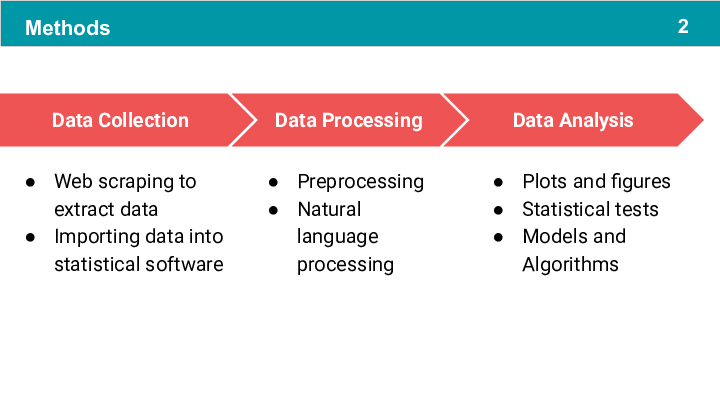

In [3]:
WImage(filename='QMESL.pdf[1]')

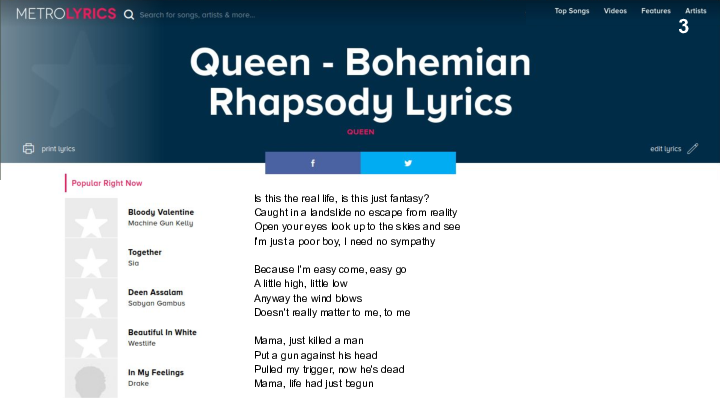

In [5]:
WImage(filename='QMESL.pdf[2]')

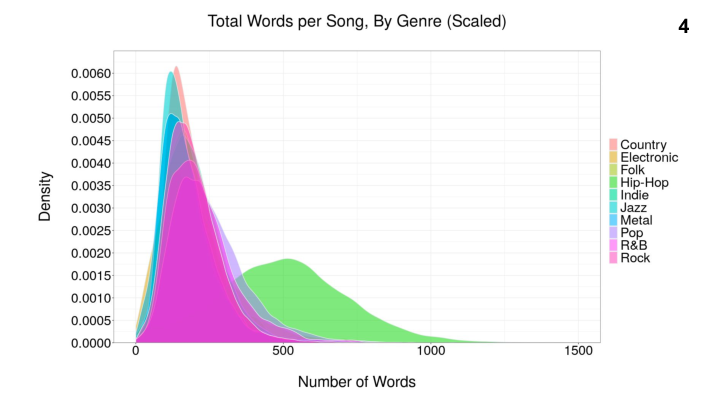

In [6]:
WImage(filename='QMESL.pdf[3]')

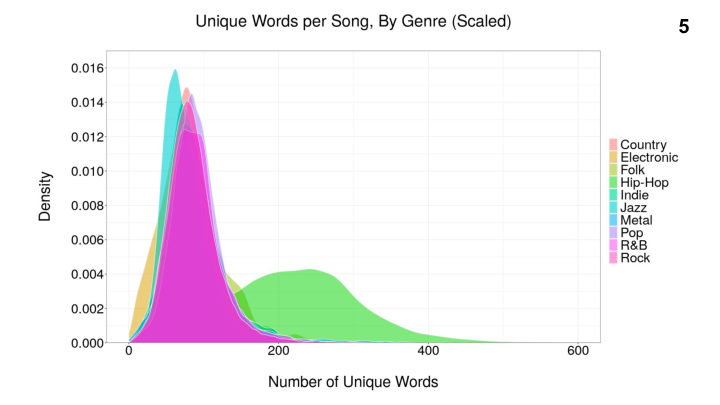

In [7]:
WImage(filename='QMESL.pdf[4]')

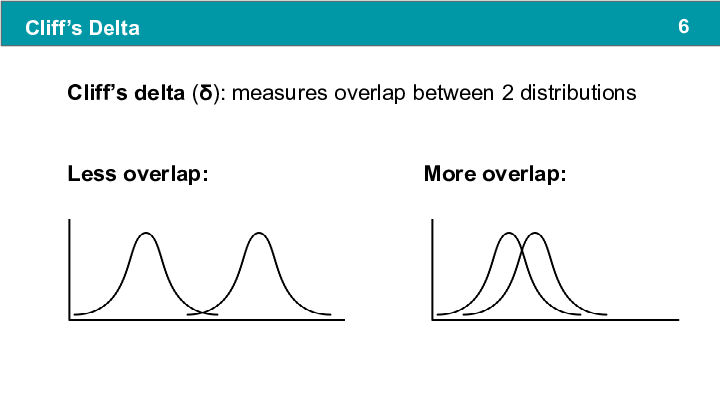

In [8]:
WImage(filename='QMESL.pdf[5]')

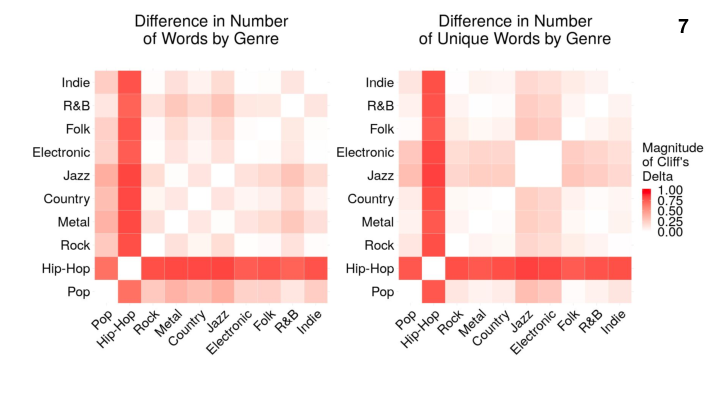

In [9]:
WImage(filename='QMESL.pdf[6]')

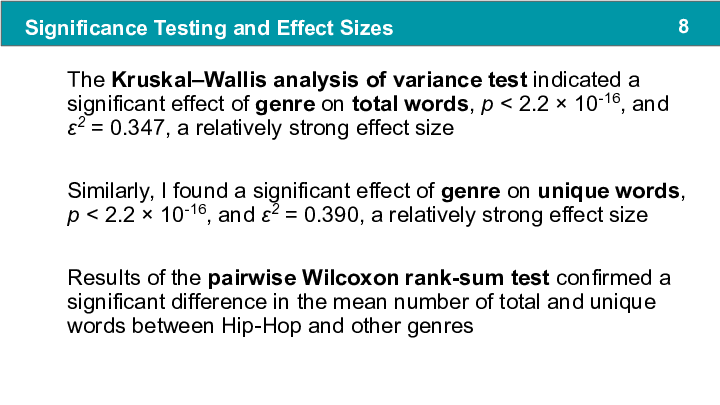

In [10]:
WImage(filename='QMESL.pdf[7]')

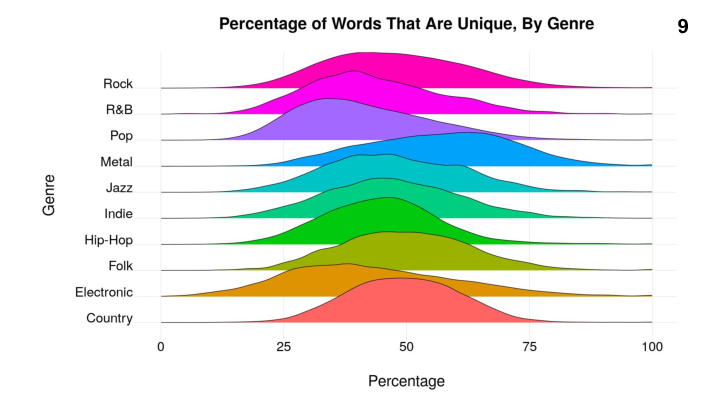

In [11]:
WImage(filename='QMESL.pdf[8]')

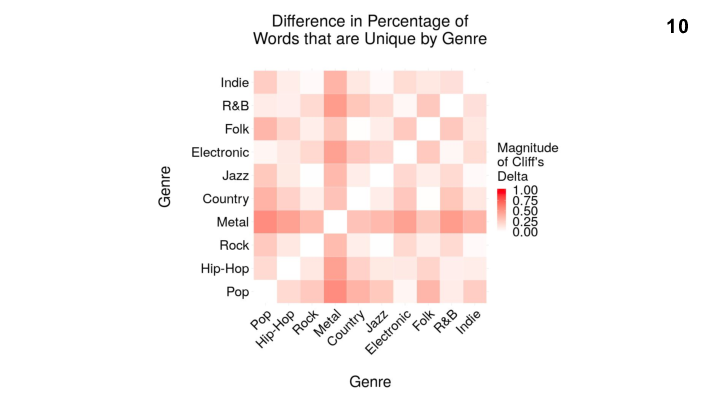

In [12]:
WImage(filename='QMESL.pdf[9]')

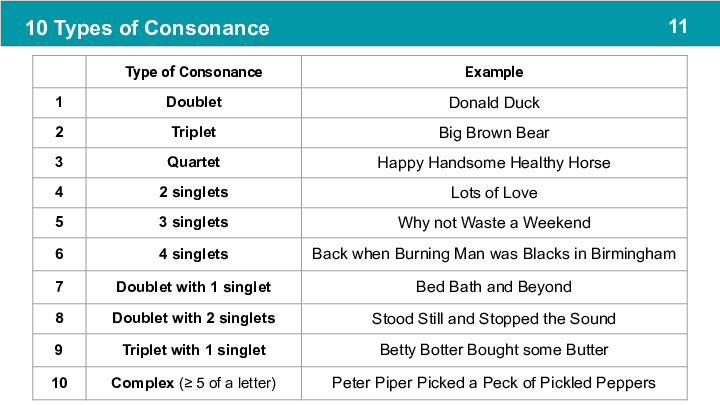

In [13]:
WImage(filename='QMESL.pdf[10]')

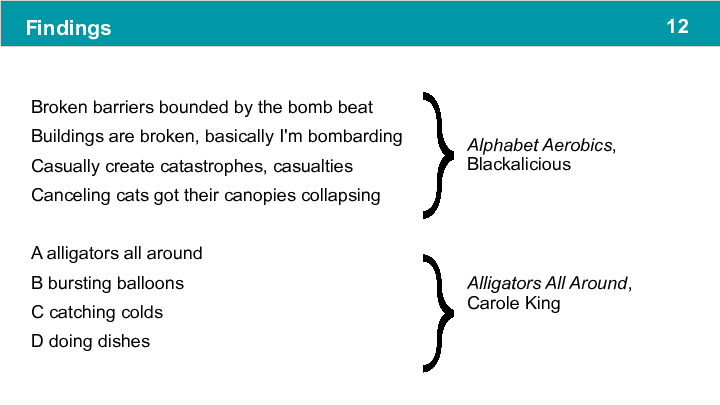

In [14]:
WImage(filename='QMESL.pdf[11]')

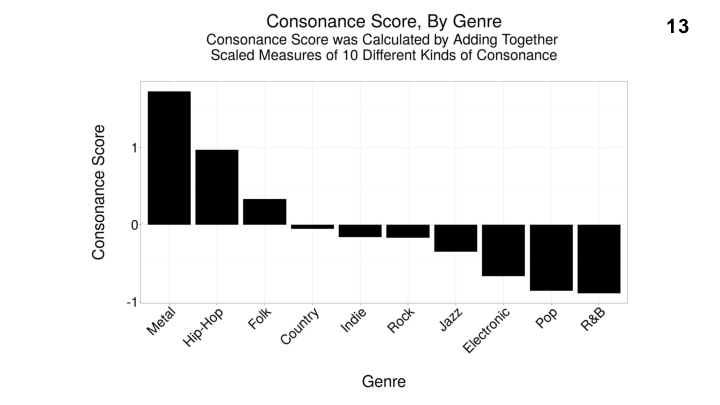

In [15]:
WImage(filename='QMESL.pdf[12]')

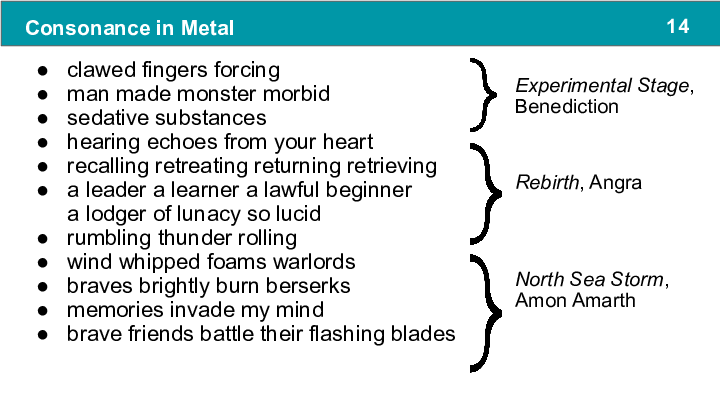

In [16]:
WImage(filename='QMESL.pdf[13]')

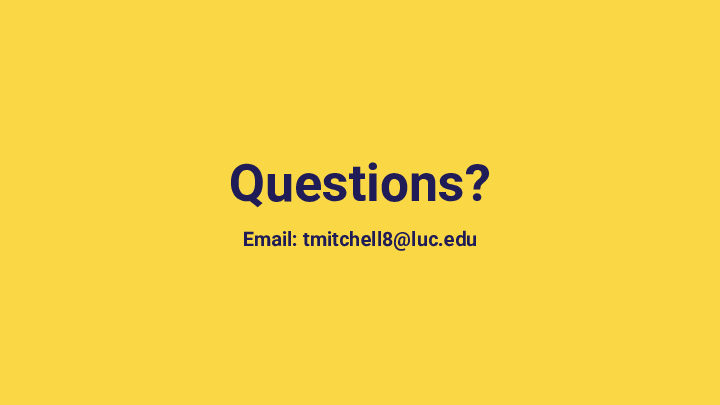

In [17]:
WImage(filename='QMESL.pdf[14]')

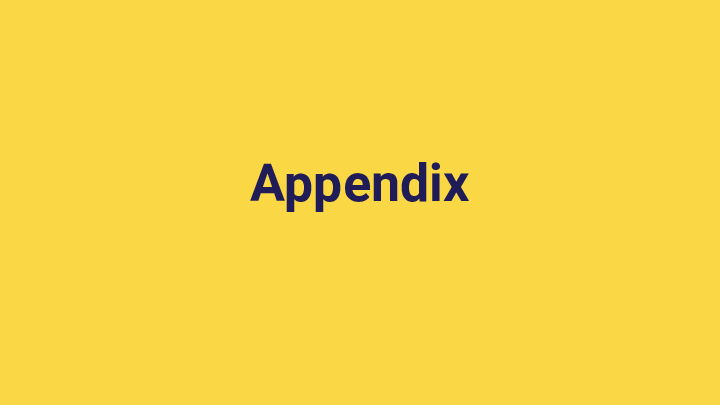

In [18]:
WImage(filename='QMESL.pdf[15]')

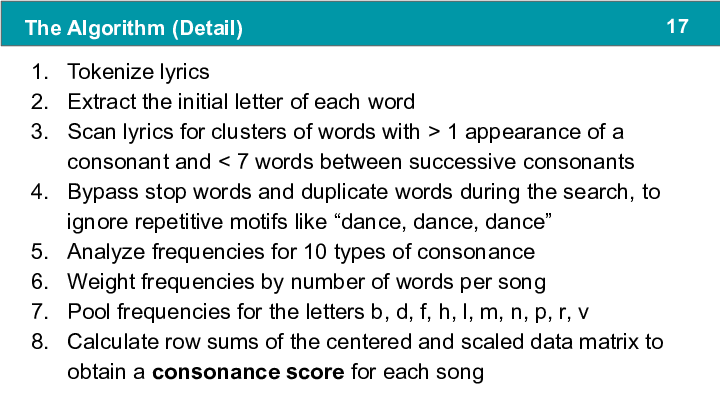

In [19]:
WImage(filename='QMESL.pdf[16]')